# Multiclass Classification With Neural Networks
## Predicting NBA player position from advanced player stats

The following notebook trains a multiclass classification model using a neural network.

Specifically, we will be training a model to classify whether we can determine an NBA player's listed position based on advanced statistics describing their play.

## Background Context

In basketball, there are five positions: `PG`, `SG`, `SF`, `PF`, `C`. Although the positions are usually mapped very closely to height/weight, each position has a traditional set of expected skills. For example `PGs` are expected to have high assist rates, `SGs` are expected to score, `SFs` are usually well-rounded or good defenders, while `PFs` and `Cs` tend to accumulate more rebounds and blocks and are usually offensive- or defensive-minded respectively.

For each player, we will scrape advanced stats that describe how the player plays. We will then determine if how a player plays alone can be used to predict player position.

## Global Configurations

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch

from torch import nn

In [2]:
ORDERED_LABELS = ['PG', 'SG', 'SF', 'PF', 'C']
POS_COLORS = {'PG': 'g', 'SG': 'c', 'SF': 'b', 'PF': 'm', 'C': 'r'}

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
def reorder_handles_labels(ax):
  handles, labels = ax.get_legend_handles_labels()
  order = list(map(lambda label: labels.index(label), ORDERED_LABELS))
  return [handles[idx] for idx in order], [labels[idx] for idx in order]

## Data Exploration

Set seed for reproducability

In [5]:
SEED = 0
if SEED is not None:
  torch.manual_seed(SEED)
  torch.cuda.manual_seed(SEED)
  print(f'Random seed: {SEED}')

Random seed: 0


### Scraping the data

All data are scraped from https://www.basketball-reference.com/leagues/NBA_2022_advanced.html.
* There are **600+** raw data points (NBA players)
* There are **11** input features (advanced stats: `TS%`, `3PAr`, `Ftr`, `ORB%`, `DRB%`, `TRB%`, `AST%`, `STL%`, `BLK%`, `TOV%`, `USG%`)
  * See [glossary](https://www.basketball-reference.com/about/glossary.html) for advanced stat descriptions
* There are **5** classes (NBA positions: `PG`, `SG`, `SF`, `PF`, `C`)

In [6]:
import requests
from bs4 import BeautifulSoup

In [7]:
ADVANCED_STATS_URL = \
  'https://www.basketball-reference.com/leagues/NBA_2022_advanced.html'
DATA_STATS = ['player', 'pos', 'team_id', 'ts_pct', 'fg3a_per_fga_pct', 
         'fta_per_fga_pct', 'orb_pct', 'drb_pct', 'trb_pct', 'ast_pct',
         'stl_pct', 'blk_pct', 'tov_pct', 'usg_pct']

In [8]:
html = requests.get(ADVANCED_STATS_URL).content
soup = BeautifulSoup(html, 'html.parser')
data = []
for row in soup.find_all('tr', {'class': 'full_table'}):
  sample = map(lambda stat: row.find('td', {'data-stat': stat}).text, DATA_STATS)
  # Convert numerical stats in sample to float or None if empty
  sample = map(lambda x: x[1] if x[0] < 3 else float(x[1]) if x[1] else None,
               enumerate(sample))
  data.append(list(sample))

### Cleaning the data

In [9]:
COLUMNS = ['Player', 'Pos', 'Tm', 'TS%', '3PAr', 'Ftr', 'ORB%', 'DRB%', 'TRB%',
           'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%']
NUMERICAL_DATA = COLUMNS[3:]

In [10]:
df = pd.DataFrame.from_records(data, columns=COLUMNS)
df = df[df['Tm'] != 'TOT'] # Filter out aggregated TOT row for multiteam players
df = df.dropna() # Drop rows with missing stat values
print('First 10 rows:')
display(df.head(10))

First 10 rows:


,Player,Pos,Tm,TS%,3PAr,Ftr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%
0,Precious Achiuwa,C,TOR,0.503,0.259,0.217,8.7,21.7,14.9,6.9,1.1,2.3,11.3,18.5
1,Steven Adams,C,MEM,0.560,0.003,0.518,17.9,22.0,19.9,16.1,1.6,2.7,19.6,12.0
2,Bam Adebayo,C,MIA,0.608,0.008,0.466,8.7,26.1,17.5,17.5,2.2,2.6,14.4,25.0
3,Santi Aldama,PF,MEM,0.452,0.364,0.242,9.4,16.1,12.6,7.7,0.8,2.5,9.9,18.4
4,LaMarcus Aldridge,C,BRK,0.604,0.100,0.223,7.8,18.7,13.4,6.3,0.6,4.0,8.0,22.4
6,Grayson Allen,SG,MIL,0.609,0.684,0.130,1.9,10.9,6.5,7.6,1.2,1.0,6.7,15.2
7,Jarrett Allen,C,CLE,0.698,0.018,0.428,12.0,24.5,18.4,8.2,1.2,3.7,12.7,18.1
8,Jose Alvarado,PG,NOP,0.520,0.374,0.180,3.2,10.2,6.6,26.9,4.2,0.8,11.2,18.4
10,Kyle Anderson,PF,MEM,0.506,0.232,0.224,4.8,21.6,13.0,16.2,2.5,2.7,12.1,16.2
11,Giannis Antetokounmpo,PF,MIL,0.633,0.194,0.615,6.6,30.4,18.7,31.7,1.6,4.0,12.2,34.9


### Visualizing the clustered data

In [11]:
import warnings
warnings.filterwarnings(action='ignore')

from sklearn.manifold import TSNE

In [12]:
N = df[COLUMNS[3:]].values # Get numerical data values
T = TSNE(n_components=2, random_state=SEED).fit_transform(N)
df['T1'] = list(map(lambda t: t[0], T))
df['T2'] = list(map(lambda t: t[1], T))

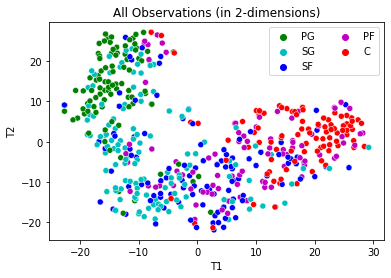

In [13]:
sns.scatterplot(x='T1', y='T2', data=df, hue='Pos', palette=POS_COLORS)
handles, labels = reorder_handles_labels(plt.gca())
plt.legend(handles, labels, ncol=2)
plt.title('All Observations (in 2-dimensions)')
plt.show()

Even when visualizing the data in lower-dimensional 2D space, we can see evidence of light clustering.

### Creating train/test data split

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
train_df, test_df = train_test_split(df, random_state=SEED)
x_train, x_test = train_df[NUMERICAL_DATA].values, test_df[NUMERICAL_DATA].values
y_train, y_test = train_df['Pos'].values, test_df['Pos'].values

## Model Fitting

### Define neural network model

In [16]:
INPUT_SIZE = 11
HIDDEN_1_SIZE = 16
HIDDEN_2_SIZE = 16
HIDDEN_3_SIZE = 8
OUTPUT_SIZE = 5

In [17]:
model = nn.Sequential(
  nn.Linear(in_features=INPUT_SIZE, out_features=HIDDEN_1_SIZE),
  nn.ReLU(),
  nn.Linear(in_features=HIDDEN_1_SIZE, out_features=HIDDEN_2_SIZE),
  nn.ReLU(),
  nn.Linear(in_features=HIDDEN_2_SIZE, out_features=HIDDEN_3_SIZE),
  nn.ReLU(),
  nn.Linear(in_features=HIDDEN_3_SIZE, out_features=OUTPUT_SIZE)
).to(device)

### Defining the `fit()` function

In [18]:
from sklearn.metrics import accuracy_score
from torch.optim import SGD

In [19]:
def fit(X_train, Y_train, X_test, Y_test,
        epochs = 100000,
        loss_fn = nn.CrossEntropyLoss(),
        accuracy_fn = accuracy_score,
        optimizer = SGD(params=model.parameters(), lr=0.001),
        verbose = 1000,
        early_stopping = 1000,
        stop_after_k = 10):
  best = {
    'state_dict': None,
    'epoch': None,
    'loss_train': None,
    'accuracy_train': None,
    'loss_test': None,
    'accuracy_test': None
  }
  early_stop_k = 0
  losses_train = []
  losses_test = []
  for epoch in range(epochs):
    # Training
    model.train()
    loss_train, accuracy_train = forward(X_train, Y_train, loss_fn, accuracy_fn)
    losses_train.append(loss_train.item())
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()
    # Testing
    model.eval()
    with torch.inference_mode():
      loss_test, accuracy_test = forward(X_test, Y_test, loss_fn, accuracy_fn)
      losses_test.append(loss_test.item())
    # Verbose Print
    if verbose and epoch % verbose == 0:
      print_results(epoch, loss_train, accuracy_train, loss_test, accuracy_test)
    # Early Stopping
    if early_stopping and epoch % early_stopping == 0:
      if not best['loss_test'] or loss_test < best['loss_test']:
        early_stop_k = 0
        best['state_dict'] = model.state_dict()
        best['epoch'] = epoch
        best['loss_train'] = loss_train
        best['accuracy_train'] = accuracy_train
        best['loss_test'] = loss_test
        best['accuracy_test'] = accuracy_test
      else:
        early_stop_k += 1
        if early_stop_k >= stop_after_k:
          print(f'\nStopping Early\nBest', end=' ')
          print_results(best['epoch'], best['loss_train'],
                        best['accuracy_train'], best['loss_test'],
                        best['accuracy_test'])
          break
  model.load_state_dict(best['state_dict'])
  return losses_train, losses_test

def forward(X, Y, loss_fn, accuracy_fn):
  logits = model(X)
  pred = torch.softmax(logits, dim=1).argmax(dim=1)
  loss = loss_fn(logits.cpu(), Y.type(torch.LongTensor))
  accuracy = accuracy_fn(Y.cpu(), pred.cpu())
  return loss, accuracy

def print_results(epoch, loss_train, accuracy_train, loss_test, accuracy_test):
  print(f'Epoch: {epoch}', end=' | ')
  print(f'Train Loss: {loss_train:.4f}', end=', ')
  print(f'Train Acc: {accuracy_train:.1%}', end=' | ')
  print(f'Test Loss: {loss_test:.4f}', end=', ')
  print(f'Test Acc: {accuracy_test:.1%}')

### Transforming the data for the model

In [20]:
from sklearn import preprocessing

In [21]:
le = preprocessing.LabelEncoder()
le.fit(ORDERED_LABELS)

LabelEncoder()

In [22]:
X_train = torch.tensor(x_train).type(torch.float).to(device)
Y_train = torch.tensor(le.transform(y_train)).type(torch.float).to(device)
X_test = torch.tensor(x_test).type(torch.float).to(device)
Y_test = torch.tensor(le.transform(y_test)).type(torch.float).to(device)

### Fitting the model

In [23]:
losses_train, losses_test = fit(X_train, Y_train, X_test, Y_test)

Epoch: 0 | Train Loss: 1.7928, Train Acc: 18.2% | Test Loss: 1.7471, Test Acc: 22.4%
Epoch: 1000 | Train Loss: 1.4163, Train Acc: 37.7% | Test Loss: 1.4507, Test Acc: 40.8%
Epoch: 2000 | Train Loss: 1.3188, Train Acc: 39.8% | Test Loss: 1.3797, Test Acc: 42.4%
Epoch: 3000 | Train Loss: 1.2686, Train Acc: 41.4% | Test Loss: 1.3402, Test Acc: 40.8%
Epoch: 4000 | Train Loss: 1.2248, Train Acc: 42.0% | Test Loss: 1.3022, Test Acc: 41.6%
Epoch: 5000 | Train Loss: 1.1779, Train Acc: 46.8% | Test Loss: 1.2595, Test Acc: 43.2%
Epoch: 6000 | Train Loss: 1.1374, Train Acc: 48.9% | Test Loss: 1.2371, Test Acc: 45.6%
Epoch: 7000 | Train Loss: 1.1130, Train Acc: 50.8% | Test Loss: 1.2215, Test Acc: 48.0%
Epoch: 8000 | Train Loss: 1.0888, Train Acc: 52.7% | Test Loss: 1.2056, Test Acc: 48.0%
Epoch: 9000 | Train Loss: 1.0715, Train Acc: 51.6% | Test Loss: 1.1939, Test Acc: 48.0%
Epoch: 10000 | Train Loss: 1.0591, Train Acc: 50.8% | Test Loss: 1.1855, Test Acc: 48.8%
Epoch: 11000 | Train Loss: 1.0486,

## Visualizing the Results

### Learning curves 

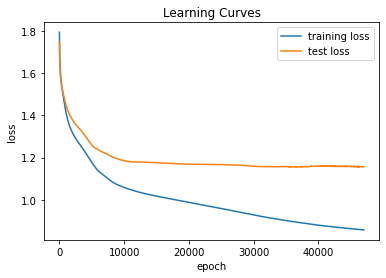

In [24]:
plt.plot(losses_train)
plt.plot(losses_test)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training loss', 'test loss'])
plt.title('Learning Curves')
plt.show()

### Comparing `test` vs `pred` observations

In [25]:
model.eval()
with torch.inference_mode():
  logits_test = model(X_test)
  y_pred = torch.softmax(logits_test, dim=1).argmax(dim=1).cpu().numpy()
test_df['Pred'] = le.inverse_transform(y_pred)

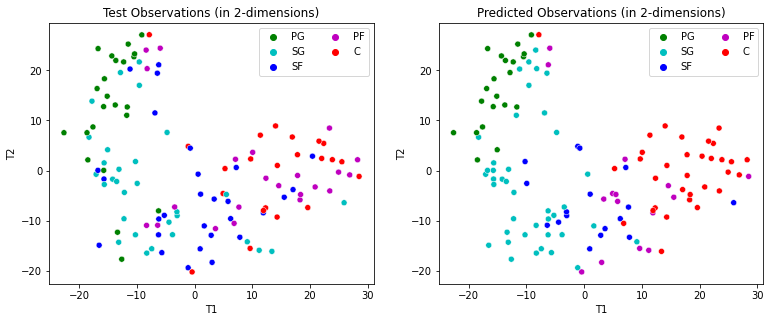

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12.8, 4.8))
# Subplot (1, 1)
sns.scatterplot(ax=ax[0], x='T1', y='T2', data=test_df, hue='Pos',
                palette=POS_COLORS)
handles, labels = reorder_handles_labels(ax[0])
ax[0].legend(handles, labels, ncol=2)
ax[0].set_title('Test Observations (in 2-dimensions)')
# Subplot (1, 2)
sns.scatterplot(ax=ax[1], x='T1', y='T2', data=test_df, hue='Pred',
                palette=POS_COLORS)
handles, labels = reorder_handles_labels(ax[1])
ax[1].legend(handles, labels, ncol=2)
ax[1].set_title('Predicted Observations (in 2-dimensions)')
plt.show()

Visually we can see that our predictions (right) captures the overall patterns in the test data (left).

### Confusion matrix

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

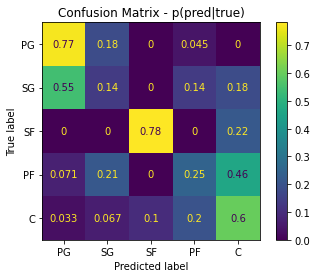

In [28]:
C = confusion_matrix(test_df['Pos'], test_df['Pred'], normalize='true')
ConfusionMatrixDisplay(C, display_labels=ORDERED_LABELS).plot()
plt.title('Confusion Matrix - p(pred|true)')
plt.show()

## Conclusion

The model performed well at predicting the `PG` and `SF` labels with accuracies over `0.75`. This may be helped by the fact that `PGs` typically have unique skillsets (specializing in assists) making them easier to distinguish. However, I'm surprised at both the high precision and recall for the `SF` class, especially since `SFs` tend to not have any distinguishing characteristics.

We see a lot of confusion predicting true `SG` and `PF` classes where `SGs` were most incorrectly classified as `PGs` and `PFs` were most incorrectly classified as `Cs`. A lot of times a tall `PG` may get classified as a `SG` or a smaller `C` as a `PF`, so this confusion is expected especially absent of any height/weight data.

In general, adding height/weight data as input features will almost certainly boost the classification accuracy, as those two features are by far the most important in determining NBA position. However, this exercise still shows that using advanced stats alone, NBA player position can be predicted with above `50%` accuracy (well above `20%` chance).